<div style='background-image: url("title01.png") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 200px'>
<div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
<div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computers, Waves, Simulations</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Finite-Difference Method - Acoustic Waves 1D</div>
        </div>
    </div>
</div>

#### This notebook covers the following aspects:

* Implementation of the 1D acoustic wave equation 
* Understanding the input parameters for the simulation and the plots that are generated
* Understanding the concepts of stability (Courant criterion)
* Modifying source and receiver locations and observing the effects on the seismograms

**Note:** Corrections implemented May 14, 2020
* Error in CFL criterion fixed
* Error in source time function fixed


#### Numerical Solution (Finite Differences Method)

The acoustic wave equation in 1D with constant density 

$$
\partial^2_t p(x,t) \ = \ c(x)^2 \partial_x^2 p(x,t) + s(x,t)
$$

with pressure $p$, acoustic velocity $c$, and source term $s$ contains two second derivatives that can be approximated with a difference formula such as

$$
\partial^2_t p(x,t) \ \approx \ \frac{p(x,t+dt) - 2 p(x,t) + p(x,t-dt)}{dt^2} 
$$

and equivalently for the space derivative. Injecting these approximations into the wave equation allows us to formulate the pressure p(x) for the time step $t+dt$ (the future) as a function of the pressure at time $t$ (now) and $t-dt$ (the past). This is called an explicit scheme allowing the $extrapolation$ of the space-dependent field into the future only looking at the nearest neighbourhood.

We replace the time-dependent (upper index time, lower indices space) part by

$$
 \frac{p_{i}^{n+1} - 2 p_{i}^n + p_{i}^{n-1}}{\mathrm{d}t^2} \ = \ c^2 ( \partial_x^2 p) \ + s_{i}^n
$$

solving for $p_{i}^{n+1}$.

The extrapolation scheme is

$$
p_{i}^{n+1} \ = \ c_i^2 \mathrm{d}t^2 \left[ \partial_x^2 p \right]
+ 2p_{i}^n - p_{i}^{n-1} + \mathrm{d}t^2 s_{i}^n
$$

The  space derivatives are determined by 

$$
\partial_x^2 p \ = \ \frac{p_{i+1}^{n} - 2 p_{i}^n + p_{i-1}^{n}}{\mathrm{d}x^2}
$$

#### Exercises: 

* Increase the dominant frequency f0 and observe how the fit with the analytical solution gets worse. Fix the frequency and change nop to 5 (longer and more accurate space derivative). Observe how the solution improves comapared to nop = 3!

* Increase dt by a factor of 2 (keeping everything else) and observe how the solution becomes unstable. 

In [1]:
# Import Libraries
# ----------------------------------------------
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display, HTML

# Sub-plot Configuration
# ----------------------
from matplotlib import gridspec 

# Progress Bar
# ----------------------
from progress_bar import ProgressBarHandler

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Parameter Configuration 
# -----------------------

nx   = 10000        # number of grid points in x-direction
xmax = 10000        # physical domain (m)
dx   = xmax/(nx-1)  # grid point distance in x-direction
c0   = 334.         # wave speed in medium (m/s)
isrc = int(nx/2)    # source location in grid in x-direction
ir   = isrc + 100          # receiver location in grid in x-direction
nt   = 600          # maximum number of time steps
dt   = 0.002        # time step
op   = 3            # Length of FD operator for 2nd space derivative (3 or 5) 
idisp = 5           # display frequency
print(op, '- point operator')

# Source time function parameters
f0   = 15. # dominant frequency of the source (Hz)
t0   = 4. / f0 # source time shift

# CPL Stability Criterion
# --------------------------
eps = c0 * dt / dx #epsilon value (corrected May 3, 2020)

print('Stability criterion =', eps)

3 - point operator
Stability criterion = 0.6679332000000001


In [3]:
# Source time function (Gaussian)
# -------------------------------
src  = np.zeros(nt + 1)
time = np.linspace(0 * dt, nt * dt, nt)
# 1st derivative of a Gaussian (corrected May 3, 2020)
src  = -8. * (time - t0) * f0 * (np.exp(-1.0 * (4*f0) ** 2 * (time - t0) ** 2))



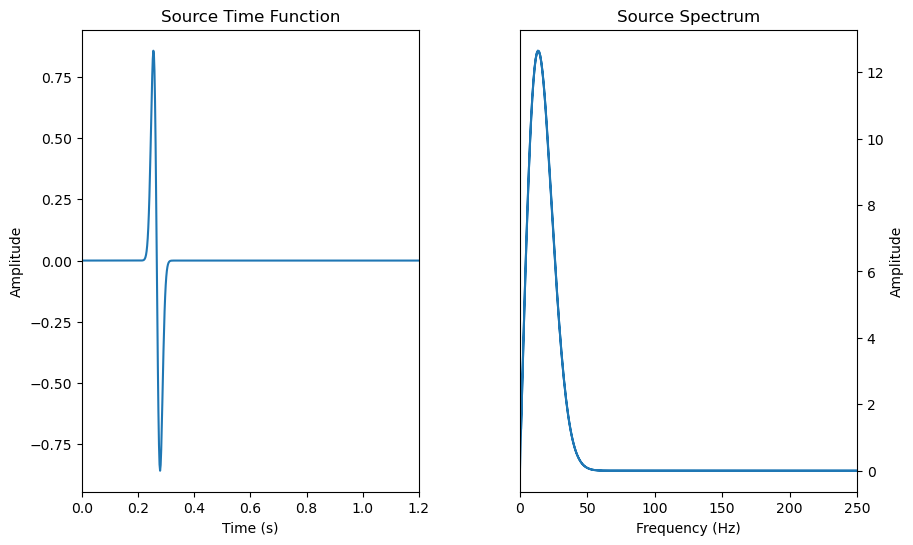

In [4]:
# Plot source time function

# Plot position configuration
# ---------------------------
plt.ion()
fig1 = plt.figure(figsize=(10, 6))
gs1  = gridspec.GridSpec(1, 2, width_ratios=[1, 1], hspace=0.3, wspace=0.3)

# Plot source time function
# -------------------------
ax1  = plt.subplot(gs1[0])
ax1.plot(time, src) # plot source time function
ax1.set_title('Source Time Function')
ax1.set_xlim(time[0], time[-1])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')

# Plot source spectrum
# --------------------
ax2  = plt.subplot(gs1[1])
spec = np.fft.fft(src) # source time function in frequency domain
freq = np.fft.fftfreq(spec.size, d = dt ) # time domain to frequency domain (corrected May 3, 2020)
ax2.plot(np.abs(freq), np.abs(spec)) # plot frequency and amplitude
ax2.set_xlim(0, 250) # only display frequency from 0 to 250 Hz
ax2.set_title('Source Spectrum')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

plt.show()

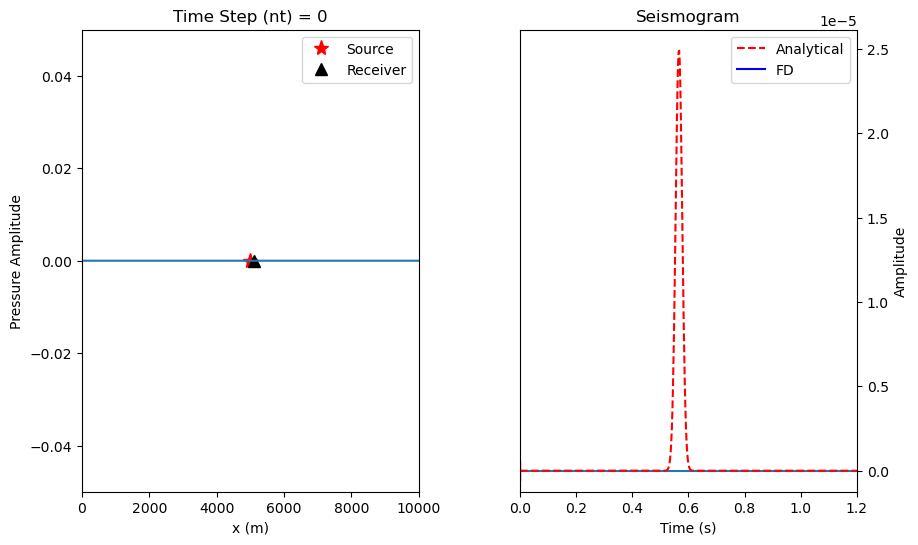

In [5]:

# 1D Wave Propagation (Finite Difference Solution) 
# ------------------------------------------------

# Initialize empty pressure
# -------------------------
p    = np.zeros(nx) # p at time n (now)
pold = np.zeros(nx) # p at time n-1 (past)
pnew = np.zeros(nx) # p at time n+1 (present)
d2px = np.zeros(nx) # 2nd space derivative of p

# Initialize model (assume homogeneous model)
# -------------------------------------------
c    = np.zeros(nx)
c    = c + c0       # initialize wave velocity in model

# Initialize coordinate
# ---------------------
x    = np.arange(nx)
x    = x * dx       # coordinate in x-direction

# Initialize empty seismogram
# ---------------------------
seis = np.zeros(nt) 

# Analytical solution
# -------------------
G    = time * 0.
for it in range(nt): # Calculate Green's function (Heaviside function)
    if (time[it] - np.abs(x[ir] - x[isrc]) / c0) >= 0:
        G[it] = 1. / (2 * c0)
Gc   = np.convolve(G, src * dt)
Gc   = Gc[0:nt]
lim  = Gc.max() # get limit value from the maximum amplitude

# Matplotlib 
# ----------
fig  = plt.figure(figsize=(10, 6))
gs   = gridspec.GridSpec(1,2,width_ratios=[1, 1],hspace=0.3, wspace=0.3)

# Plot 1D wave propagation
# ------------------------
ax1 = plt.subplot(gs[0])
leg1, = ax1.plot(isrc, 0, 'r*', markersize=11) # plot position of the source in snapshot
leg2, = ax1.plot(ir, 0, 'k^', markersize=8) # plot position of the receiver in snapshot
up1, = ax1.plot(p) # plot pressure update each time step
ax1.set_xlim(0, xmax)
ax1.set_ylim(-np.max(p), np.max(p))
ax1.set_title('Time Step (nt) = 0')
ax1.set_xlabel('x (m)')
ax1.set_ylabel('Pressure Amplitude')
ax1.legend((leg1, leg2), ('Source', 'Receiver'), loc='upper right', fontsize=10, numpoints=1)

# Plot seismogram 
# ---------------
ax2  = plt.subplot(gs[1])
leg3, = ax2.plot(0,0,'r--',markersize=1) # plot analytical solution marker
leg4, = ax2.plot(0,0,'b-',markersize=1) # plot numerical solution marker
up21, = ax2.plot(time, seis) # update recorded seismogram each time step
up22, = ax2.plot([0], [0], 'r|', markersize=15) # update time step position
anal, = ax2.plot(time, Gc, 'r--') # plot analytical solution
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlim(time[0], time[-1])
ax2.set_title('Seismogram')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude')
ax2.legend((leg3, leg4), ('Analytical', 'FD'), loc='upper right', fontsize=10, numpoints=1)

None

In [6]:
# Progress Bar
progress_handler = ProgressBarHandler(nt, '1D Acoustic Wave Simulation')

# Simulation Results
p_results = np.zeros((nt//idisp, nx))
seis_results = np.zeros((nt//idisp, nt))

window = 100
xshift = 25

for it in range(nt):
    if op==3: # use 3 point operator FD scheme
        for i in range(1, nx - 1):
            d2px[i] = (p[i + 1] - 2 * p[i] + p[i - 1]) / dx ** 2

    if op==5: # use 5 point operator FD scheme
        for i in range(2, nx - 2):
            d2px[i] = (-1./12 * p[i + 2] + 4./3  * p[i + 1] - 5./2 * p[i] \
                    +4./3  * p[i - 1] - 1./12 * p[i - 2]) / dx ** 2

    # Time Extrapolation
    # ------------------
    pnew = 2 * p - pold + c ** 2 * dt ** 2 * d2px

    # Add Source Term at isrc
    # -----------------------
    # Absolute pressure w.r.t analytical solution
    pnew[isrc] = pnew[isrc] + src[it] / (dx) * dt ** 2
    
            
    # Remap Time Levels
    # -----------------
    pold, p = p, pnew
    
    # Output Seismogram
    # -----------------
    seis[it] = p[ir]

    if it % idisp == 0:
        p_results[it//idisp] = p
        seis_results[it//idisp] = seis

    progress_handler(it)

1D Acoustic Wave Simulation
[████████████████████] 100.00% 600/600           


In [7]:
from animation import create_animation_gaussian_analytical

ani = create_animation_gaussian_analytical(locals())

display(HTML(ani.to_jshtml()))

plt.close()